# JIRA data extraction 
-------------------------------------
## Goal : track pending requests with our customers.

>1. Analyze historic evolution 
>2. Predict future evolution (nb of requests, amount (euros or day/man), for each lot)

# 1. Analyze historic evolution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from py2neo import Graph, authenticate, Relationship
from sklearn import preprocessing
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm, datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import Perceptron as PPN
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import plotly.offline as py
py.init_notebook_mode(connected=True)
import pandas_profiling
import random, os


In [2]:
data = pd.DataFrame.from_csv("jira_sales.csv")
data = data.reset_index()

In [3]:
data.head()

,Creation,jira,montant,jours,activite,lot,perimetre
0,2015-07-17 19:01:00,SIOPCGI-1162,11480.0,28.0,Change,Lot I,GRC
1,2015-07-20 13:54:00,SIOPCGI-1163,18758.0,41.5,Change,Lot F,MSTR
2,2015-07-20 14:13:00,SIOPCGI-1164,NaN,NaN,RUN,Lot A,ETL
3,2015-07-20 14:15:00,SIOPCGI-1165,NaN,NaN,RUN,NaN,NaN
4,2015-07-20 14:16:00,SIOPCGI-1166,NaN,NaN,RUN,Lot A,ETL


In [4]:
pandas_profiling.ProfileReport(data)

Number of variables,7
Number of observations,4783
Total Missing (%),8.1%
Total size in memory,261.6 KiB
Average record size in memory,56.0 B
Numeric,1
Categorical,3
Date,1
Text (Unique),1
Rejected,1
Distinct count,4670


In [5]:
# amount = days * dayly tax
data = data.drop(["montant"], axis=1)
# remove last line (date is 1969)
data = data[:-1]

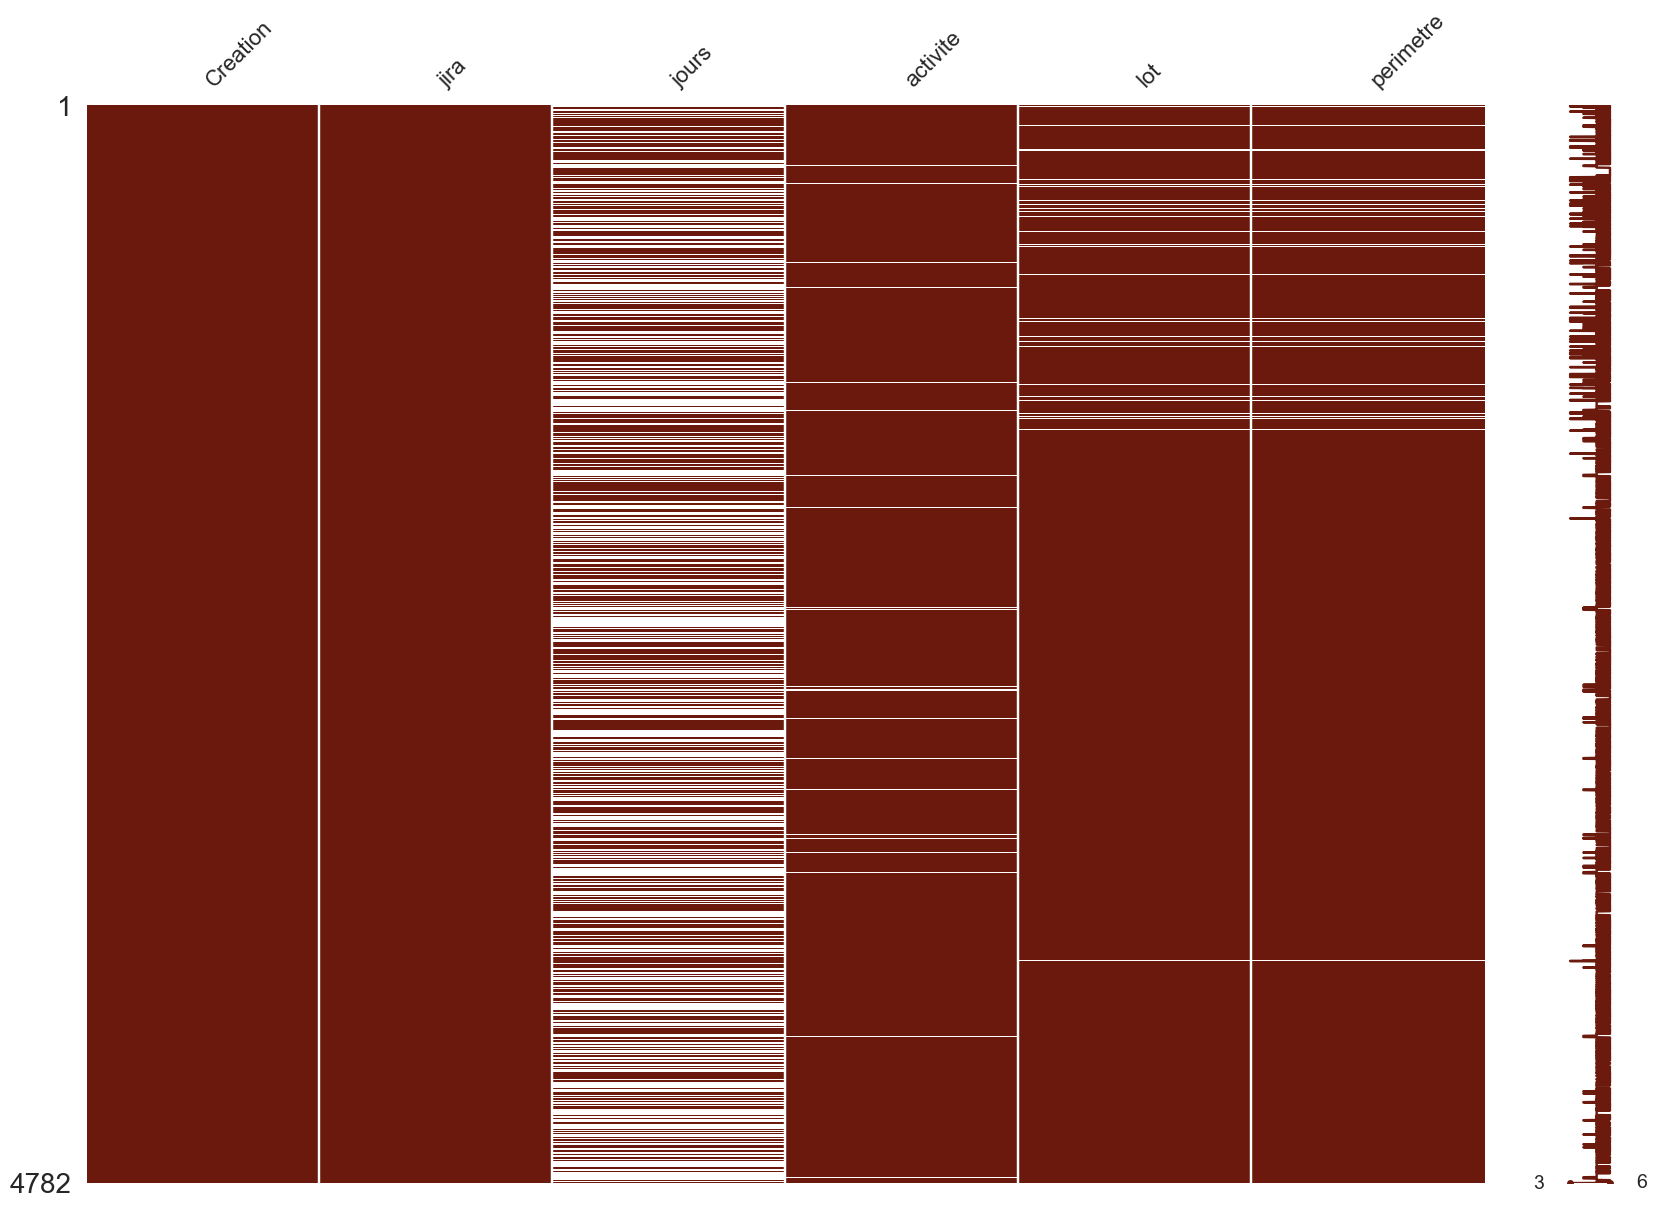

In [6]:
import missingno as msno
msno.matrix(df=data, figsize=(20, 14), color=(0.42, 0.1, 0.05))

 ## Manage missing values depending of data type

In [7]:
g = data.columns.to_series().groupby(data.dtypes).groups
groups = {k.name: v for k, v in g.items()}
print (groups)

for col in groups.get('float64'):
    data[col] = data[col].replace(np.NaN, -1)
for col in groups.get('object'):
    data[col] = data[col].replace(np.NaN, "")
    
# jours : 49.1 % of missing values  ->  when needed, use a subset with only non NaN values
# Alternative : replace by average or median 

{'datetime64[ns]': Index(['Creation'], dtype='object'), 'float64': Index(['jours'], dtype='object'), 'object': Index(['jira', 'activite', 'lot', 'perimetre'], dtype='object')}


## Transform datetime

In [8]:
from datetime import datetime
from datetime import date

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return abs((d2 - d1).days)

def months_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return (d1.year - d2.year) * 12 + d1.month - d2.month


print(data.Creation[0])

years = [data.Creation[i].year for i in range(len(data))]
data["year"] =  years
months = [months_between(str(date), str(data.Creation[0])) for date in data.Creation]
data["month"] =  months
days = [days_between(str(date), str(data.Creation[0])) for date in data.Creation]
data["day"] =  days

2015-07-17 19:01:00


In [9]:
# One Hot encoding 
from sklearn.preprocessing import LabelEncoder
for feature in ["activite","lot","perimetre"]:
    dummy = pd.get_dummies(data[feature],prefix_sep='_',prefix=feature)
    data = pd.concat([data, dummy], axis=1)

In [10]:
data.head()

,Creation,jira,jours,activite,lot,perimetre,year,month,day,activite_,...,lot_,lot_Lot A,lot_Lot B,lot_Lot F,lot_Lot I,perimetre_,perimetre_ ETL,perimetre_ GRC,perimetre_ MSTR,perimetre_ SAS
0,2015-07-17 19:01:00,SIOPCGI-1162,28.0,Change,Lot I,GRC,2015,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,2015-07-20 13:54:00,SIOPCGI-1163,41.5,Change,Lot F,MSTR,2015,0,3,0,...,0,0,0,1,0,0,0,0,1,0
2,2015-07-20 14:13:00,SIOPCGI-1164,-1.0,RUN,Lot A,ETL,2015,0,3,0,...,0,1,0,0,0,0,1,0,0,0
3,2015-07-20 14:15:00,SIOPCGI-1165,-1.0,RUN,,,2015,0,3,0,...,1,0,0,0,0,1,0,0,0,0
4,2015-07-20 14:16:00,SIOPCGI-1166,-1.0,RUN,Lot A,ETL,2015,0,3,0,...,0,1,0,0,0,0,1,0,0,0


In [11]:
# First visualize data regarding nb of lines (without days number information)

keepCols = ['year','month','day','jours','activite_', 'activite_Change', 'activite_RUN', 'lot_', 'lot_Lot A ', 'lot_Lot B ', 'lot_Lot F ',
       'lot_Lot I ', 'perimetre_', 'perimetre_ ETL', 'perimetre_ GRC',
       'perimetre_ MSTR', 'perimetre_ SAS']

yearly = data[keepCols].groupby(data.year).sum()   
monthly = data[keepCols].groupby(data.month).sum()  
dayly = data[keepCols].groupby(data.day).sum()


In [12]:
def plot_periodically (df, features=[], legend=[], title="", xlabel="", ylabel="", xtic=1) :
    """
    Plot data grouped per period
    @param: df: transformed DataFrame (after groupby(period) operation)
    @param: features
    @param: legend
    @param: title
    @param: xlabel
    @param: ylabel
    @param: xtic    
    """
    
    # to avoid mistakes, sort by size
    # Not totally working for monthly
    sums = [df[feature].sum() for feature in features ]
    sums2, features = zip(*sorted(zip(sums, features)))
    sums3, legend = zip(*sorted(zip(sums, legend)))
    
    
    
    if not legend:
        legend = features
        
    plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    N = len(df)
    
    f = []
    for i,feature in enumerate(features) :
        f.append(df[feature].tolist())
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    pi = []
    for i,feature in enumerate(f) :
        if i==0:
            pi.append(plt.bar(ind, f[0], width))
        else :
            pi.append(plt.bar(ind, f[i], width, bottom=f[i-1]))
  
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.xticks(np.arange(0, N, xtic))
    plt.yticks()
    
    plt.legend((pi), (legend))
    plt.show()

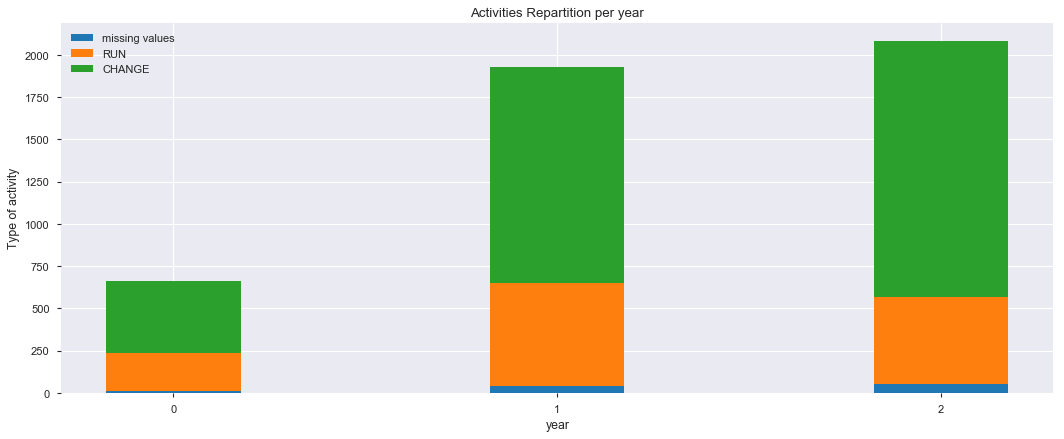

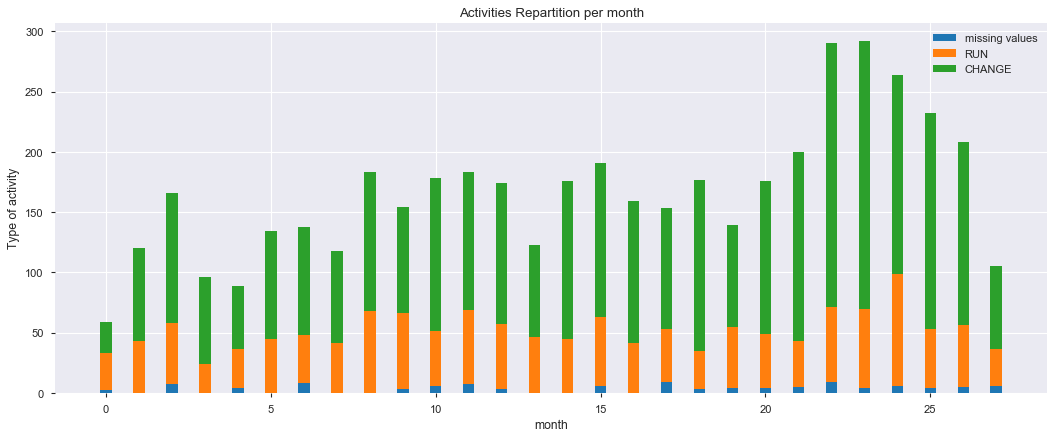

In [13]:
# Activities
plot_periodically (yearly, features=['activite_', 'activite_Change', 'activite_RUN'],
                   legend=["missing values", "CHANGE", "RUN"], title="Activities Repartition per year",
                   xlabel='year', ylabel='Type of activity', xtic=1)
plot_periodically (monthly, features=['activite_', 'activite_Change', 'activite_RUN'],
                   legend=["missing values", "CHANGE", "RUN"], title="Activities Repartition per month",
                   xlabel='month', ylabel='Type of activity', xtic=5)




> Activities : increase each year, thanks to increasing of change

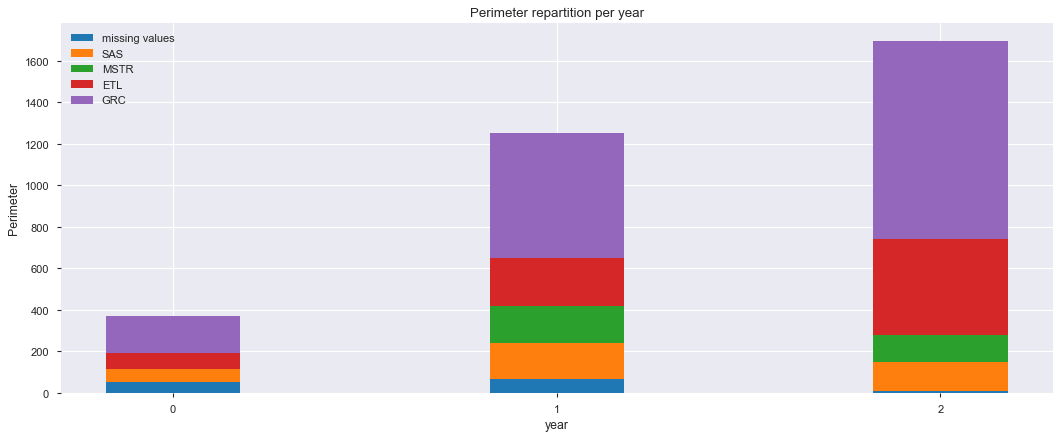

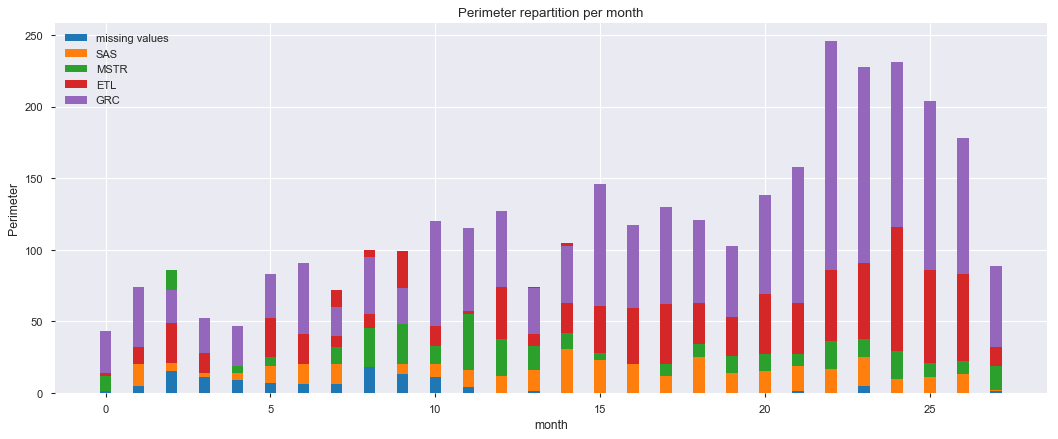

In [14]:
# Perimeter
plot_periodically (yearly, features=['perimetre_', 'perimetre_ ETL', 'perimetre_ GRC','perimetre_ MSTR',
                                      'perimetre_ SAS'],legend=["missing values", "ETL", "GRC", "MSTR", "SAS"],
                  title="Perimeter repartition per year", xlabel='year', ylabel="Perimeter", xtic=1)
plot_periodically (monthly, features=['perimetre_', 'perimetre_ ETL', 'perimetre_ GRC','perimetre_ MSTR',
                                      'perimetre_ SAS'],legend=["missing values", "ETL", "GRC", "MSTR", "SAS"],
                  title="Perimeter repartition per month", xlabel='month', ylabel="Perimeter", xtic=5)

* Better use of JIRA with time (less missing values)
* New perimeter MSTR stable during the last 2 years
* GRC and ETL are growing
* SAS seems to be stable for the last 2 years

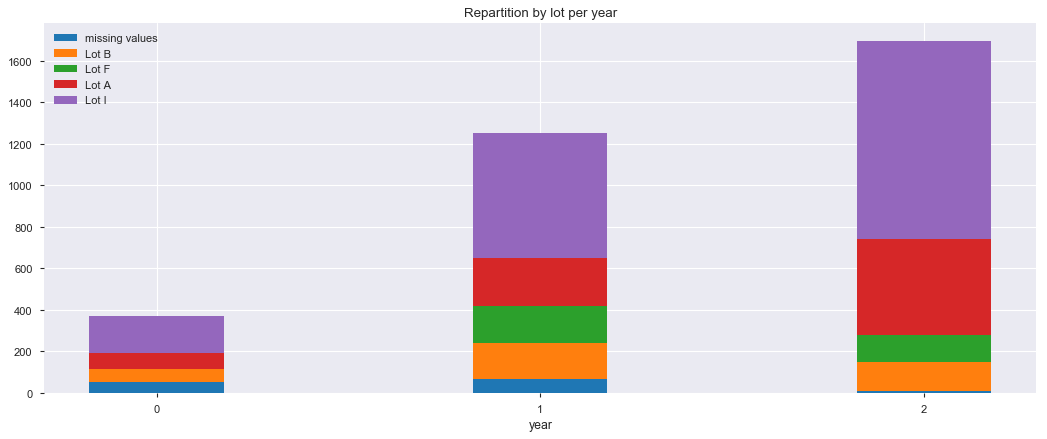

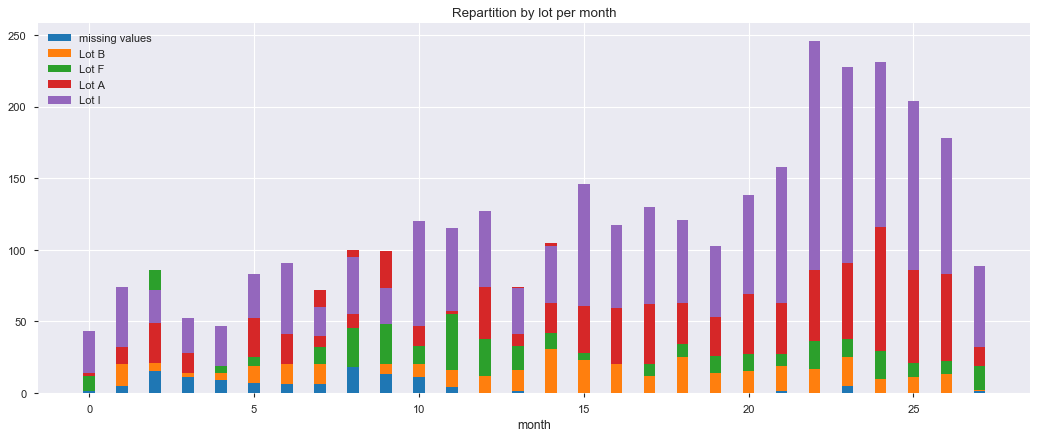

In [15]:
# Lots
plot_periodically (yearly, features=["lot_","lot_Lot A ","lot_Lot B ","lot_Lot F ","lot_Lot I "],
                   legend=["missing values", "Lot A", "Lot B", "Lot F", "Lot I"], title="Repartition by lot per year",
                   xlabel='year', ylabel='', xtic=1)

plot_periodically (monthly, features=["lot_","lot_Lot A ","lot_Lot B ","lot_Lot F ","lot_Lot I "],
                   legend=["missing values", "Lot A", "Lot B", "Lot F", "Lot I"], title="Repartition by lot per month",
                   xlabel='month', ylabel='', xtic=5)

* Lots A and I are growing
* Lot B, F are stable


# Using days

In [16]:
dataJ = data[data["jours"]!=-1]

In [17]:
keepCols = ['year','month','day','jours','activite_', 'activite_Change', 'activite_RUN', 'lot_', 'lot_Lot A ', 'lot_Lot B ', 'lot_Lot F ',
       'lot_Lot I ', 'perimetre_', 'perimetre_ ETL', 'perimetre_ GRC',
       'perimetre_ MSTR', 'perimetre_ SAS']

yearly = dataJ[keepCols].groupby(dataJ.year).sum()   
monthly = dataJ[keepCols].groupby(dataJ.month).sum()  
weekly = dataJ[keepCols].groupby(dataJ.day//7).sum() 
dayly = dataJ[keepCols].groupby(dataJ.day).sum()


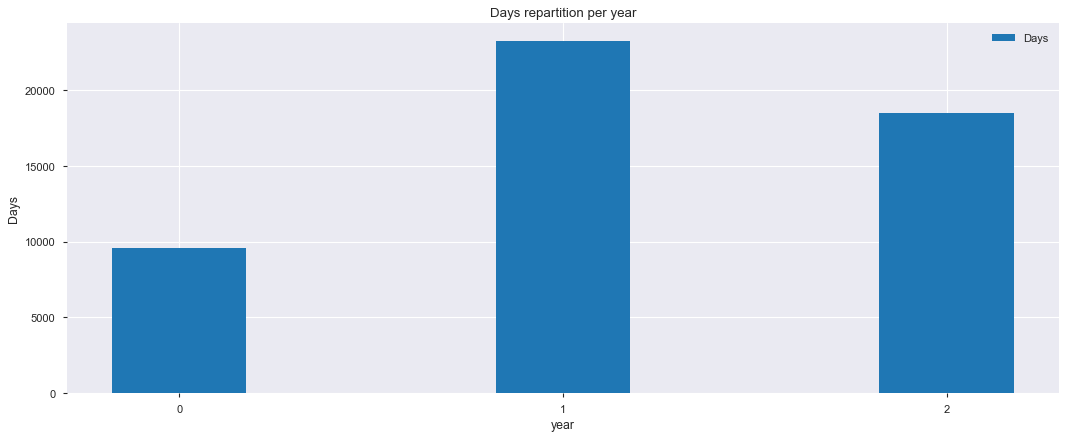

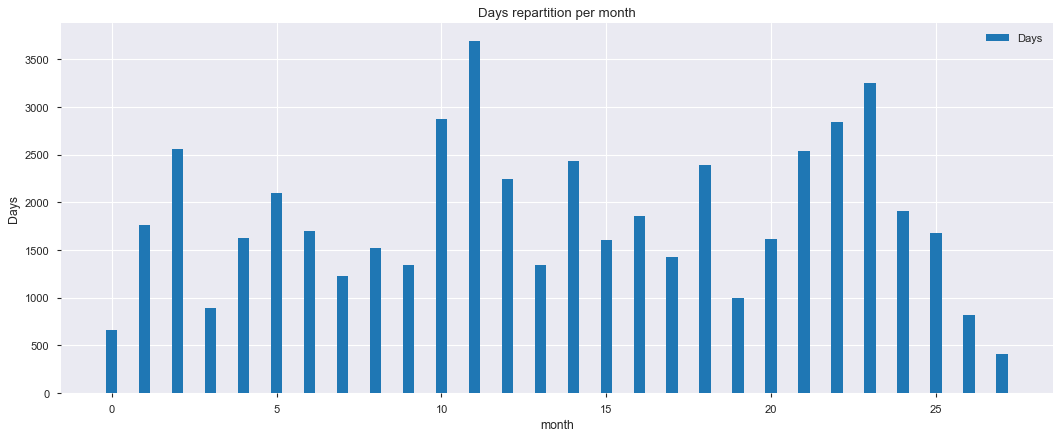

In [18]:
# Perimeter
plot_periodically (yearly, features=['jours'],legend=["Days"],
                  title="Days repartition per year", xlabel='year', ylabel="Days", xtic=1)
plot_periodically (monthly, features=['jours'],legend=["Days"],
                  title="Days repartition per month", xlabel='month', ylabel="Days", xtic=5)

* More requests in 2017 but more days in 2016

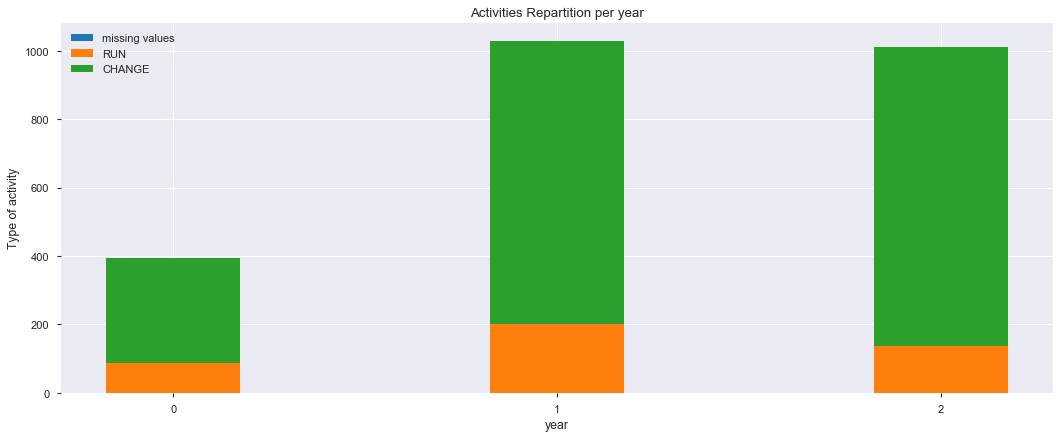

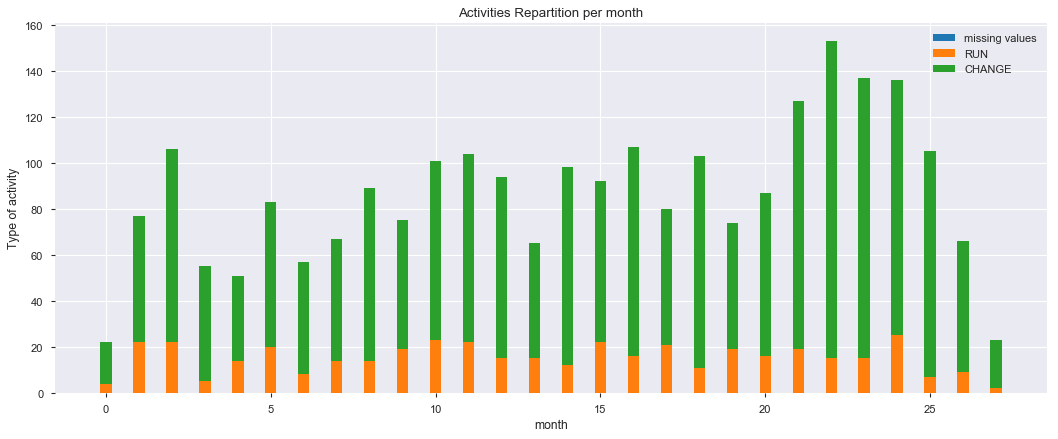

In [19]:
# Activities
plot_periodically (yearly, features=['activite_', 'activite_Change', 'activite_RUN'],
                   legend=["missing values", "CHANGE", "RUN"], title="Activities Repartition per year",
                   xlabel='year', ylabel='Type of activity', xtic=1)
plot_periodically (monthly, features=['activite_', 'activite_Change', 'activite_RUN'],
                   legend=["missing values", "CHANGE", "RUN"], title="Activities Repartition per month",
                   xlabel='month', ylabel='Type of activity', xtic=5)


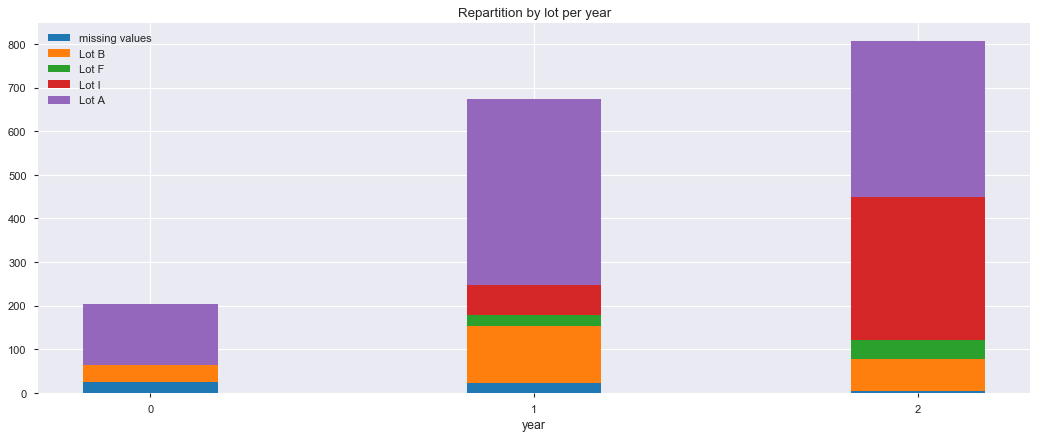

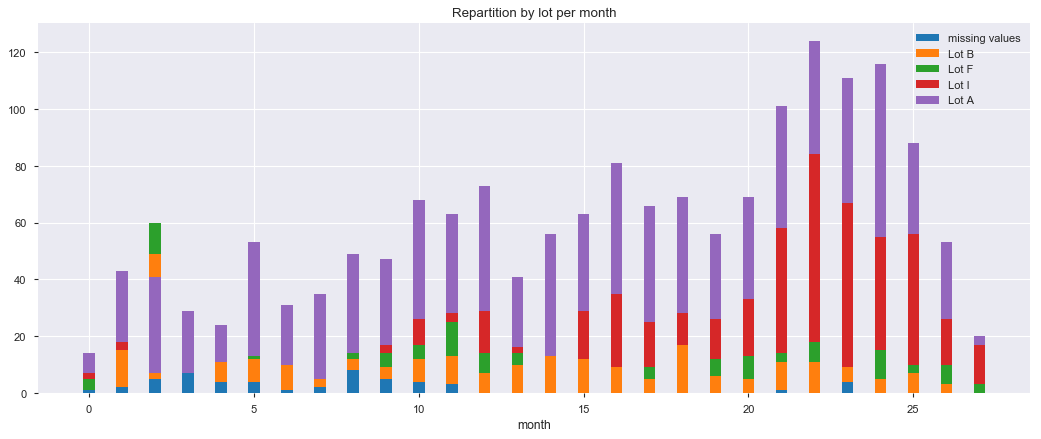

In [20]:
# Lots
plot_periodically (yearly, features=["lot_","lot_Lot A ","lot_Lot B ","lot_Lot F ","lot_Lot I "],
                   legend=["missing values", "Lot A", "Lot B", "Lot F", "Lot I"], title="Repartition by lot per year",
                   xlabel='year', ylabel='', xtic=1)

plot_periodically (monthly, features=["lot_","lot_Lot A ","lot_Lot B ","lot_Lot F ","lot_Lot I "],
                   legend=["missing values", "Lot A", "Lot B", "Lot F", "Lot I"], title="Repartition by lot per month",
                   xlabel='month', ylabel='', xtic=5)

In [21]:
LotA = data[data["lot"]=="Lot A "]
LotB = data[data["lot"]=="Lot B "]
LotF = data[data["lot"]=="Lot F "]
LotI = data[data["lot"]=="Lot I "]

In [22]:
keepCols = ['jours', 'activite_', 'activite_Change','activite_RUN', 'perimetre_',
            'perimetre_ ETL', 'perimetre_ GRC','perimetre_ MSTR', 'perimetre_ SAS']
LotA_monthly = LotA[keepCols].groupby(LotA.month).sum()  
LotB_monthly = LotB[keepCols].groupby(LotB.month).sum()  
LotF_monthly = LotF[keepCols].groupby(LotF.month).sum()  
LotI_monthly = LotI[keepCols].groupby(LotI.month).sum()  


In [23]:
def drop_null_columns(df):
    droped=[]
    for col in keepCols:
        if col in df.columns and df[col].sum()==0 :
            droped.append(col)
    df = df.drop(droped, axis=1, errors='ignore')
    print(df.columns)
    return df

LotA_monthly = drop_null_columns(LotA_monthly)
LotB_monthly = drop_null_columns(LotB_monthly)
LotF_monthly = drop_null_columns(LotF_monthly)
LotI_monthly = drop_null_columns(LotI_monthly)


Index(['jours', 'activite_', 'activite_Change', 'activite_RUN',
       'perimetre_ ETL'],
      dtype='object')
Index(['jours', 'activite_', 'activite_Change', 'activite_RUN',
       'perimetre_ SAS'],
      dtype='object')
Index(['jours', 'activite_Change', 'activite_RUN', 'perimetre_ MSTR'], dtype='object')
Index(['jours', 'activite_', 'activite_Change', 'activite_RUN',
       'perimetre_ GRC'],
      dtype='object')


In [24]:
LotA_monthly.to_csv("LotA_monthly.csv")
LotB_monthly.to_csv("LotB_monthly.csv")
LotF_monthly.to_csv("LotF_monthly.csv")
LotI_monthly.to_csv("LotI_monthly.csv")
